In [1]:
# Feature Extraction pour le projet "To bee or not to bee"
# IG.2412 & IG.2411 - Classification d'insectes pollinisateurs

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

from PIL import Image
import cv2
from tqdm import tqdm
from skimage import measure, feature, color, morphology

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, silhouette_score
)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import umap

warnings.filterwarnings('ignore')

# Définition des chemins
# Mettez ici le chemin absolu ou relatif correct vers votre dossier de données
DATA_DIR = "train"  # À modifier selon votre structure
IMAGES_DIR = os.path.join(DATA_DIR, "images")
MASKS_DIR = os.path.join(DATA_DIR, "masks")
EXCEL_FILE = os.path.join(DATA_DIR, "classif.xlsx")  # Fichier Excel avec les classifications

# Chargement des données de classification
def load_classification_data():
    """Charger les données de classification depuis le fichier Excel"""
    df = pd.read_excel(EXCEL_FILE)
    print(f"Données chargées: {len(df)} insectes")
    print(df.head())
    return df

# Fonction pour charger une image et son masque
def load_image_and_mask(image_id):
    """Charger une image et son masque de segmentation"""
    # Ajustez le format du nom de fichier selon votre structure
    image_path = os.path.join(IMAGES_DIR, f"{image_id}.jpg")  # ou .png selon votre format
    mask_path = os.path.join(MASKS_DIR, f"binary_{image_id}.tif")  # ajustez selon votre format
    
    # Chargement de l'image en RGB
    image = np.array(Image.open(image_path))
    
    # Chargement du masque (supposé en noir et blanc)
    mask = np.array(Image.open(mask_path).convert('L'))
    # Binarisation du masque si nécessaire (0 = fond, 255 = insecte)
    mask = (mask > 0).astype(np.uint8) * 255
    
    return image, mask

# 1. Extraction de caractéristiques de forme et symétrie
def extract_shape_features(mask):
    """Extraire les caractéristiques de forme et symétrie à partir du masque"""
    # Obtenir les propriétés de région du masque binaire
    mask_binary = mask > 0
    props = measure.regionprops(mask_binary.astype(int))[0]
    
    # Caractéristiques de forme
    area = props.area  # Aire
    perimeter = props.perimeter  # Périmètre
    eccentricity = props.eccentricity  # Excentricité (0=cercle, 1=ligne)
    solidity = props.solidity  # Solidité (ratio aire/enveloppe convexe)
    extent = props.extent  # Étendue (ratio aire/rectangle englobant)
    
    # Mesures additionnelles de forme
    major_axis_length = props.major_axis_length
    minor_axis_length = props.minor_axis_length
    aspect_ratio = major_axis_length / minor_axis_length if minor_axis_length > 0 else 0
    
    # Mesure de symétrie horizontale
    height, width = mask_binary.shape
    left_half = mask_binary[:, :width//2]
    right_half = mask_binary[:, width//2:]
    right_half_flipped = np.fliplr(right_half)
    
    # Calculer la taille commune pour la comparaison
    min_width = min(left_half.shape[1], right_half_flipped.shape[1])
    horizontal_symmetry = np.sum(left_half[:, :min_width] == right_half_flipped[:, :min_width]) / (height * min_width)
    
    # Retourner un dictionnaire des caractéristiques
    shape_features = {
        'area': area,
        'perimeter': perimeter,
        'eccentricity': eccentricity,
        'solidity': solidity,
        'extent': extent,
        'aspect_ratio': aspect_ratio,
        'horizontal_symmetry': horizontal_symmetry
    }
    
    return shape_features

# 2. Ratio pixels insecte / pixels image totale
def calculate_bug_ratio(mask):
    """Calculer le ratio de pixels de l'insecte par rapport à l'image totale"""
    bug_pixels = np.sum(mask > 0)
    total_pixels = mask.size
    ratio = bug_pixels / total_pixels
    return ratio

# 3. Extraction des caractéristiques de couleur
def extract_color_features(image, mask):
    """Extraire les caractéristiques de couleur (RGB) à partir de l'image et du masque"""
    # Créer un masque booléen
    mask_bool = mask > 0
    
    # Extraire les pixels de l'insecte pour chaque canal
    r_channel = image[:, :, 0][mask_bool]
    g_channel = image[:, :, 1][mask_bool]
    b_channel = image[:, :, 2][mask_bool]
    
    # Caractéristiques demandées pour chaque canal
    color_features = {
        # Minimum
        'r_min': np.min(r_channel) if len(r_channel) > 0 else 0,
        'g_min': np.min(g_channel) if len(g_channel) > 0 else 0,
        'b_min': np.min(b_channel) if len(b_channel) > 0 else 0,
        
        # Maximum
        'r_max': np.max(r_channel) if len(r_channel) > 0 else 0,
        'g_max': np.max(g_channel) if len(g_channel) > 0 else 0,
        'b_max': np.max(b_channel) if len(b_channel) > 0 else 0,
        
        # Moyenne
        'r_mean': np.mean(r_channel) if len(r_channel) > 0 else 0,
        'g_mean': np.mean(g_channel) if len(g_channel) > 0 else 0,
        'b_mean': np.mean(b_channel) if len(b_channel) > 0 else 0,
        
        # Médiane
        'r_median': np.median(r_channel) if len(r_channel) > 0 else 0,
        'g_median': np.median(g_channel) if len(g_channel) > 0 else 0,
        'b_median': np.median(b_channel) if len(b_channel) > 0 else 0,
        
        # Écart-type
        'r_std': np.std(r_channel) if len(r_channel) > 0 else 0,
        'g_std': np.std(g_channel) if len(g_channel) > 0 else 0,
        'b_std': np.std(b_channel) if len(b_channel) > 0 else 0
    }
    
    return color_features

# 4. Features additionnelles (2 au choix)
def extract_additional_features(image, mask):
    """Extraire des caractéristiques additionnelles au choix"""
    mask_bool = mask > 0
    
    # Feature 1: Texture (Local Binary Pattern)
    # Conversion en niveau de gris pour texture
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if image.shape[2] == 3 else image
    
    # Calcul du LBP
    radius = 3
    n_points = 8 * radius
    lbp = feature.local_binary_pattern(gray, n_points, radius, method='uniform')
    lbp_bug = lbp[mask_bool]
    
    # Histogramme des valeurs LBP pour obtenir une signature de texture
    n_bins = int(n_points + 2)
    hist, _ = np.histogram(lbp_bug, bins=n_bins, range=(0, n_bins), density=True)
    
    # Feature 2: Moments d'inertie (moments invariants de Hu)
    moments = cv2.moments(mask)
    hu_moments = cv2.HuMoments(moments).flatten()
    
    # Transformation logarithmique des moments de Hu pour réduire la plage de valeurs
    hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments))
    
    # Retourner un dictionnaire des caractéristiques additionnelles
    additional_features = {
        'texture_entropy': np.sum(-hist * np.log2(hist + 1e-10)),  # Entropie de la texture
        'texture_energy': np.sum(hist ** 2),  # Énergie de la texture
        'hu_moment1': hu_moments[0],
        'hu_moment2': hu_moments[1],
        'hu_moment3': hu_moments[2],
        'hu_moment4': hu_moments[3]
    }
    
    return additional_features

# 5. Fonction principale pour extraire toutes les features
def extract_all_features(image_id):
    """Extraire toutes les caractéristiques pour une image donnée"""
    # Charger l'image et son masque
    image, mask = load_image_and_mask(image_id)
    
    # Extraire les différentes caractéristiques
    shape_features = extract_shape_features(mask)
    bug_ratio = calculate_bug_ratio(mask)
    color_features = extract_color_features(image, mask)
    additional_features = extract_additional_features(image, mask)
    
    # Combiner toutes les caractéristiques
    features = {
        'image_id': image_id,
        'bug_ratio': bug_ratio,
        **shape_features,
        **color_features,
        **additional_features
    }
    
    return features

# 6. Extraire les caractéristiques pour toutes les images d'entraînement
def extract_features_for_all_images(df):
    """Extraire les caractéristiques pour toutes les images listées dans le DataFrame"""
    all_features = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extraction des caractéristiques"):
        image_id = row['ID']  # Ajustez selon le nom de votre colonne ID
        try:
            features = extract_all_features(image_id)
            
            # Ajouter les étiquettes de classe
            features['bug_type'] = row['bug type']  # Ajustez selon le nom de votre colonne
            features['species'] = row['species'] if 'species' in row else None  # Ajustez selon le nom de votre colonne
            
            all_features.append(features)
        except Exception as e:
            print(f"Erreur lors du traitement de l'image {image_id}: {e}")
    
    # Convertir en DataFrame
    features_df = pd.DataFrame(all_features)
    
    return features_df

# 7. Normalisation des caractéristiques
def normalize_features(features_df):
    """Normaliser les caractéristiques"""
    # Exclure les colonnes non numériques
    non_numeric_cols = ['image_id', 'bug_type', 'species']
    numeric_cols = [col for col in features_df.columns if col not in non_numeric_cols]
    
    # Normaliser les colonnes numériques
    scaler = StandardScaler()
    features_df[numeric_cols] = scaler.fit_transform(features_df[numeric_cols])
    
    return features_df, scaler

# 8. Exécution du code
if __name__ == "__main__":
    # Charger les données de classification
    classification_df = load_classification_data()
    
    # Extraire les caractéristiques pour toutes les images
    print("Extraction des caractéristiques...")
    features_df = extract_features_for_all_images(classification_df)
    
    # Sauvegarder les caractéristiques brutes
    features_df.to_csv("features_raw.csv", index=False)
    print(f"Caractéristiques brutes sauvegardées: {features_df.shape[0]} images, {features_df.shape[1]} caractéristiques")
    
    # Normaliser les caractéristiques
    print("Normalisation des caractéristiques...")
    normalized_features_df, scaler = normalize_features(features_df)
    
    # Sauvegarder les caractéristiques normalisées
    normalized_features_df.to_csv("features_normalized.csv", index=False)
    print(f"Caractéristiques normalisées sauvegardées dans 'features_normalized.csv'")
    
    # Aperçu des caractéristiques
    print("\nAperçu des caractéristiques extraites:")
    print(normalized_features_df.head())
    
    # Statistiques descriptives
    print("\nStatistiques descriptives des caractéristiques:")
    print(normalized_features_df.describe())

Données chargées: 250 insectes
   ID bug type         species
0   1      Bee  Apis mellifera
1   2      Bee  Apis mellifera
2   3      Bee  Apis mellifera
3   4      Bee  Apis mellifera
4   5      Bee  Apis mellifera
Extraction des caractéristiques...


Extraction des caractéristiques:  62%|██████▏   | 154/250 [22:14<09:53,  6.18s/it]

Erreur lors du traitement de l'image 154: [Errno 2] No such file or directory: 'train\\masks\\binary_154.tif'


Extraction des caractéristiques: 100%|██████████| 250/250 [36:15<00:00,  8.70s/it]

Caractéristiques brutes sauvegardées: 249 images, 32 caractéristiques
Normalisation des caractéristiques...
Caractéristiques normalisées sauvegardées dans 'features_normalized.csv'

Aperçu des caractéristiques extraites:
   image_id  bug_ratio      area  perimeter  eccentricity  solidity    extent  \
0         1  -0.922879 -0.920743   0.923508     -1.840969 -0.357956  0.359219   
1         2  -0.855969 -0.853888   1.092247     -0.466644 -1.079572 -0.370322   
2         3  -0.050633 -0.049212   2.358337     -2.863697 -0.543896 -0.213604   
3         4  -0.580327 -0.578472   2.282055      0.473882 -0.709462 -0.414667   
4         5  -0.819591 -0.817539   0.722691     -0.097962 -1.070276 -0.720376   

   aspect_ratio  horizontal_symmetry     r_min  ...     g_std     b_std  \
0     -0.993786             1.186486 -0.014109  ... -0.453931 -1.359154   
1     -0.576714             1.085925 -0.515982  ... -0.741867 -1.534155   
2     -1.143557            -0.339217 -0.348691  ...  1.282631  0.63

Données chargées: 249 échantillons avec 32 caractéristiques


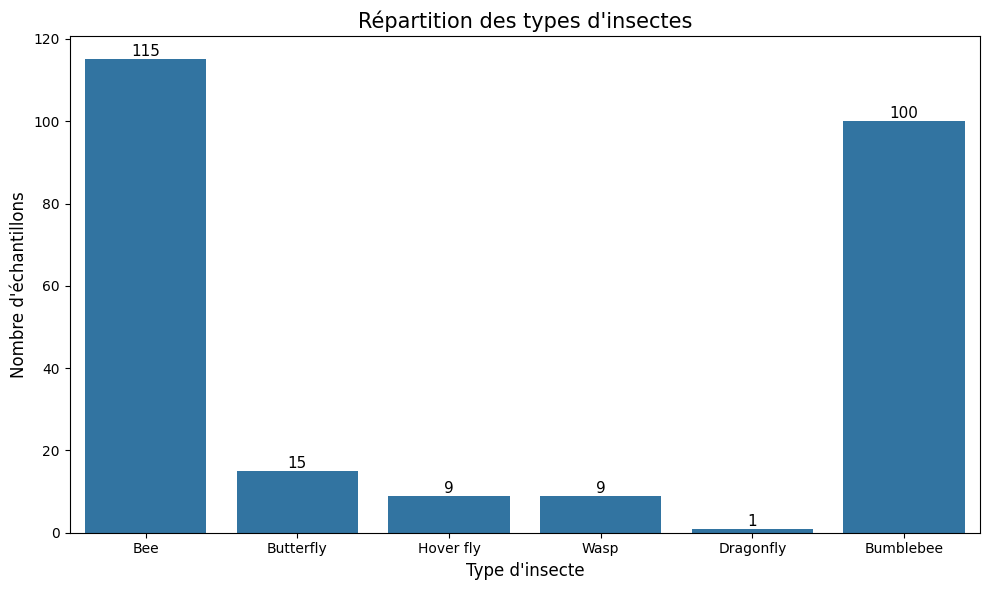

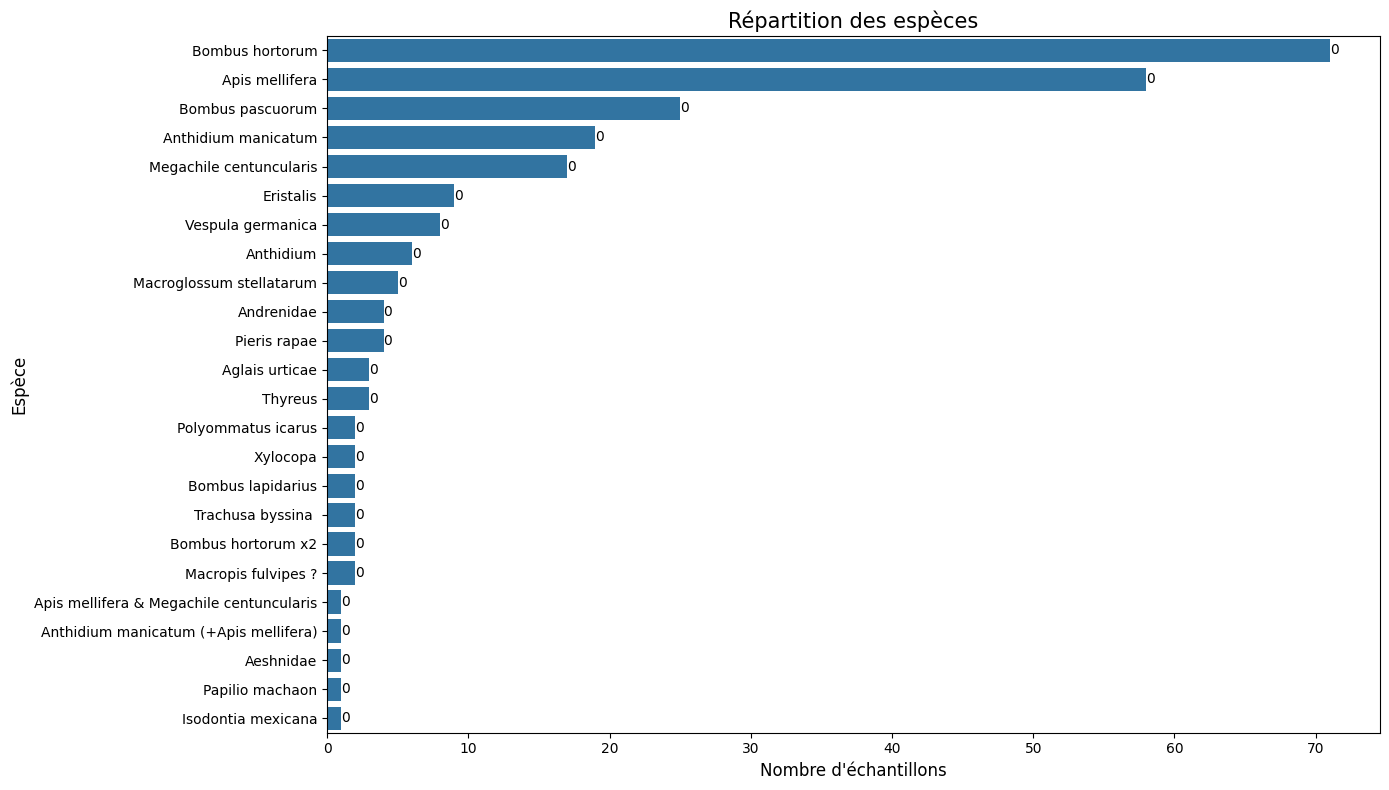

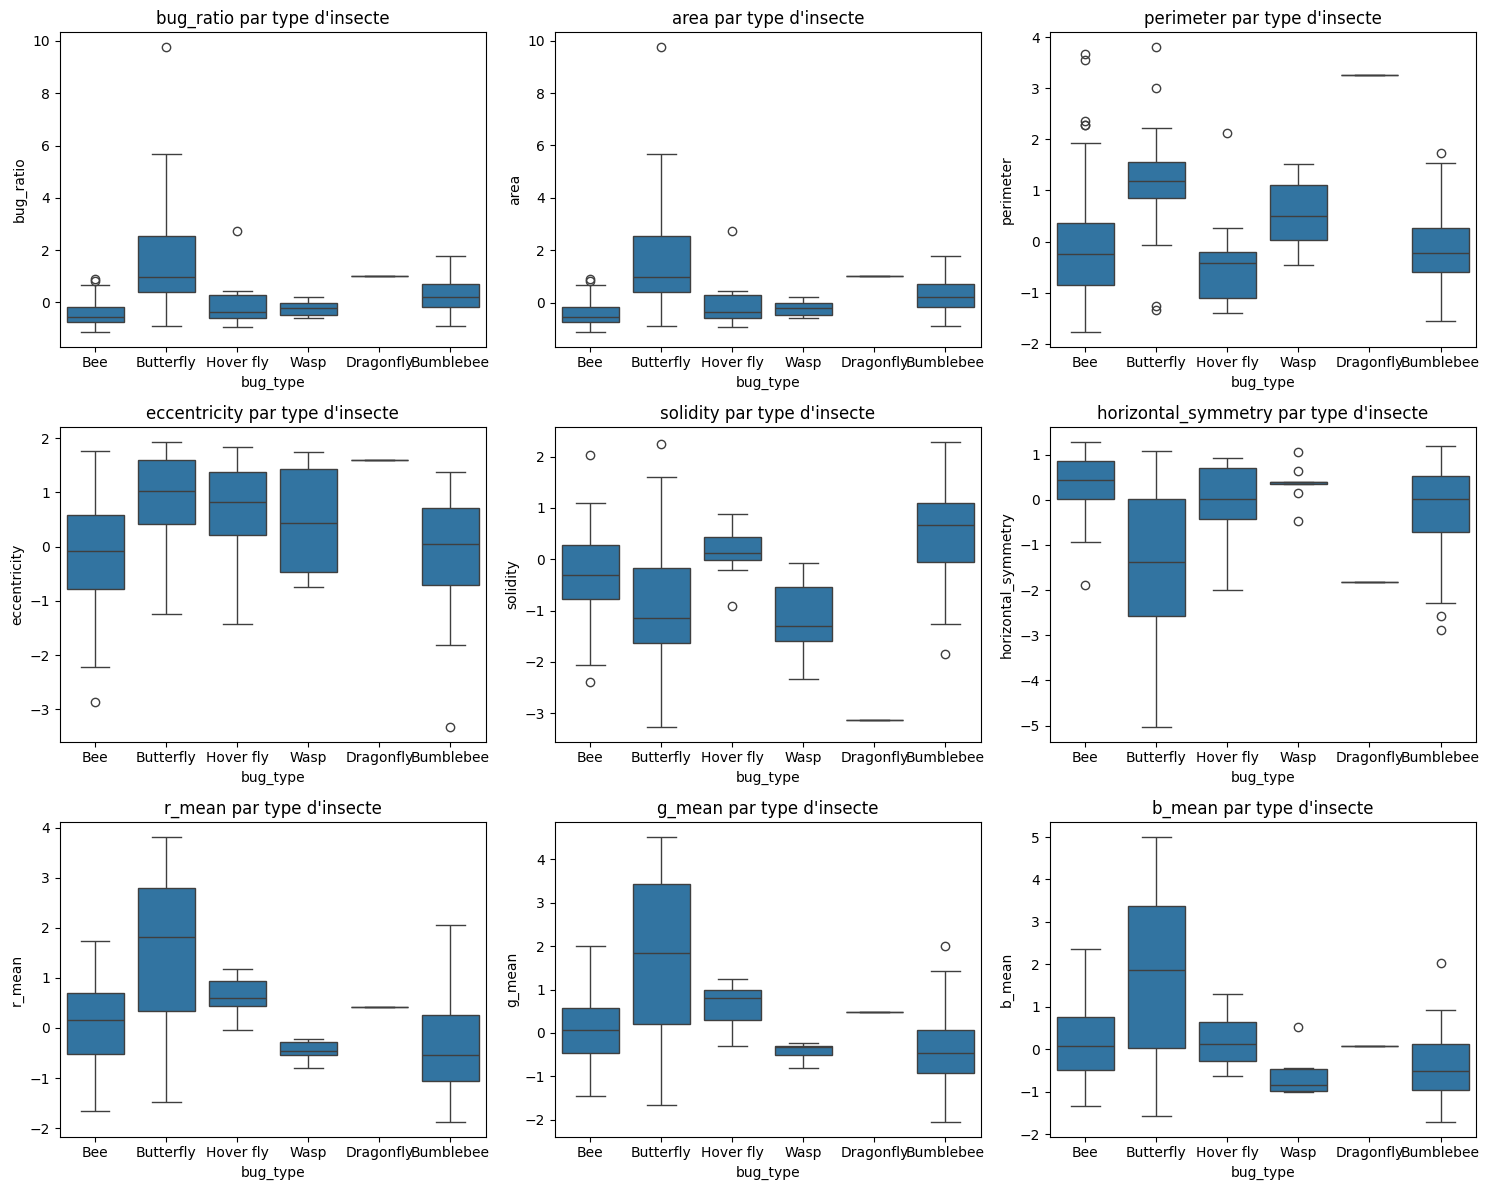

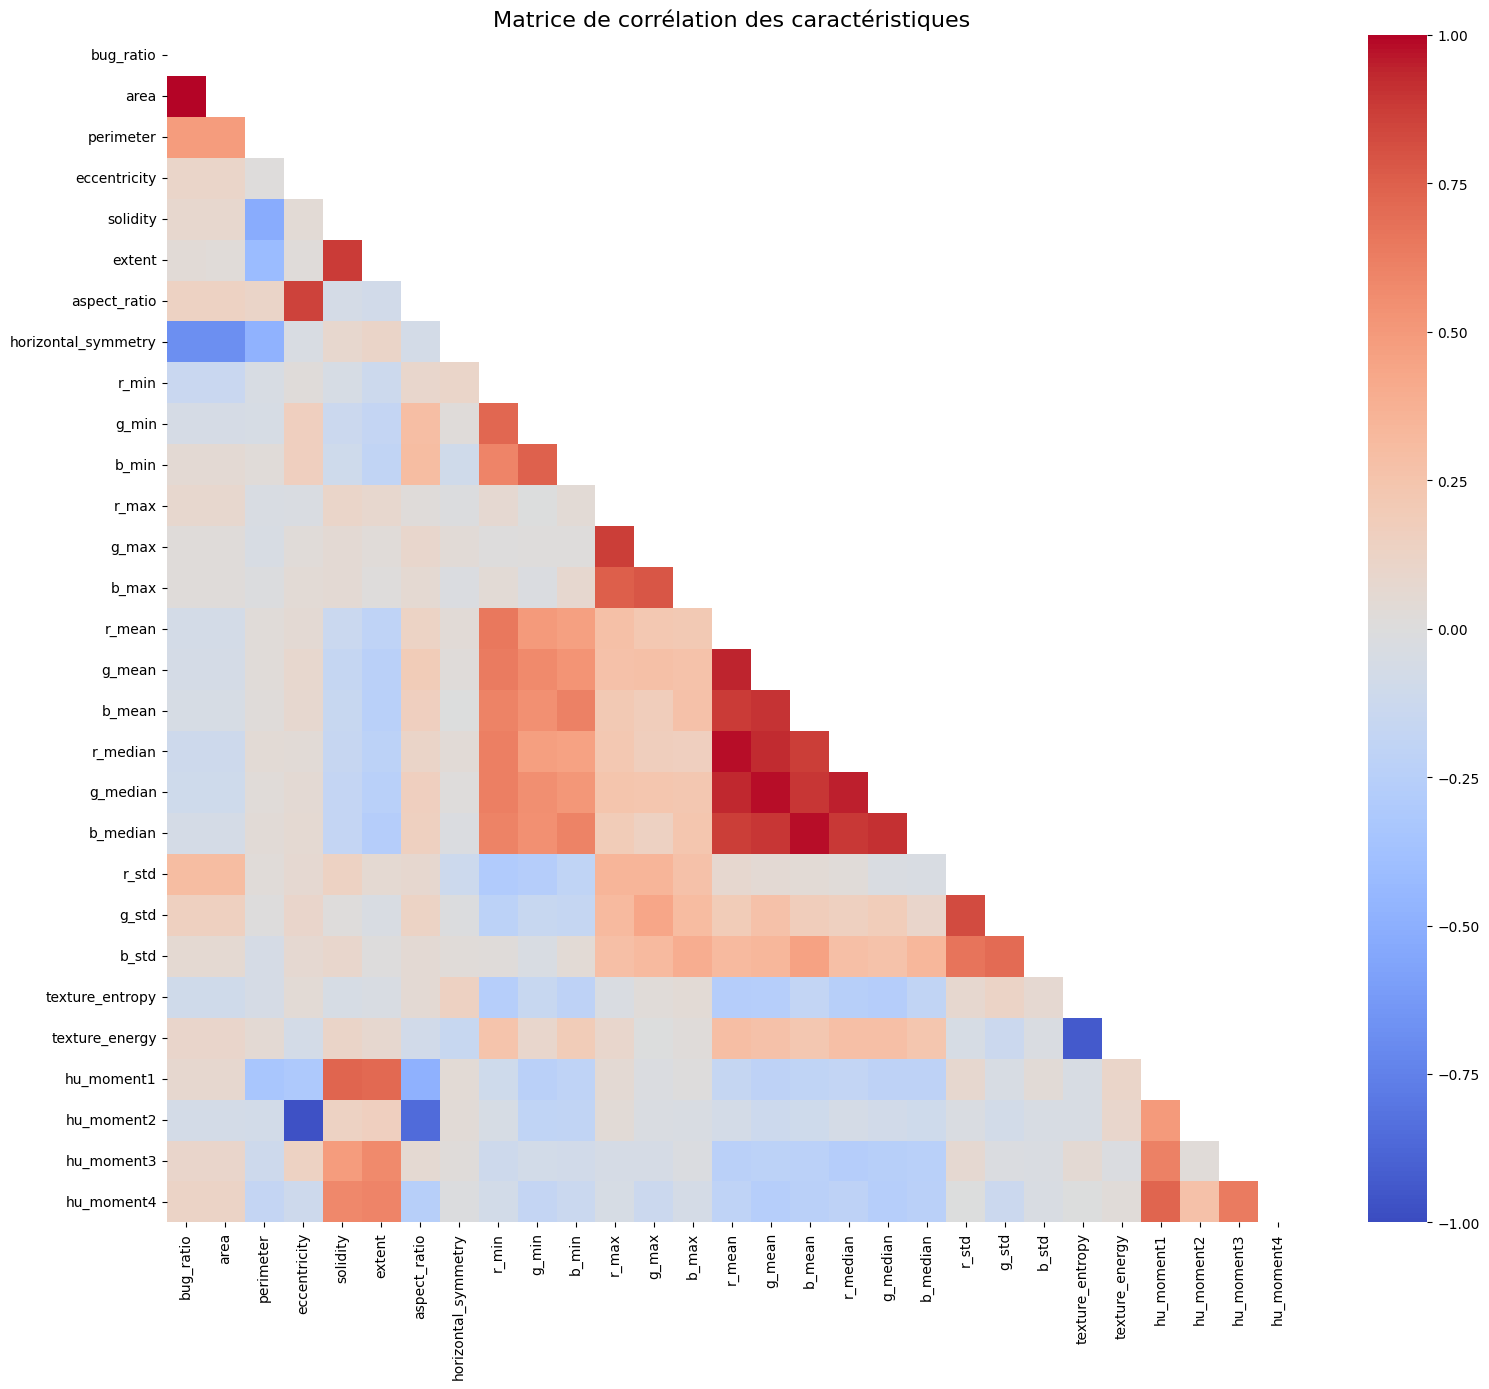

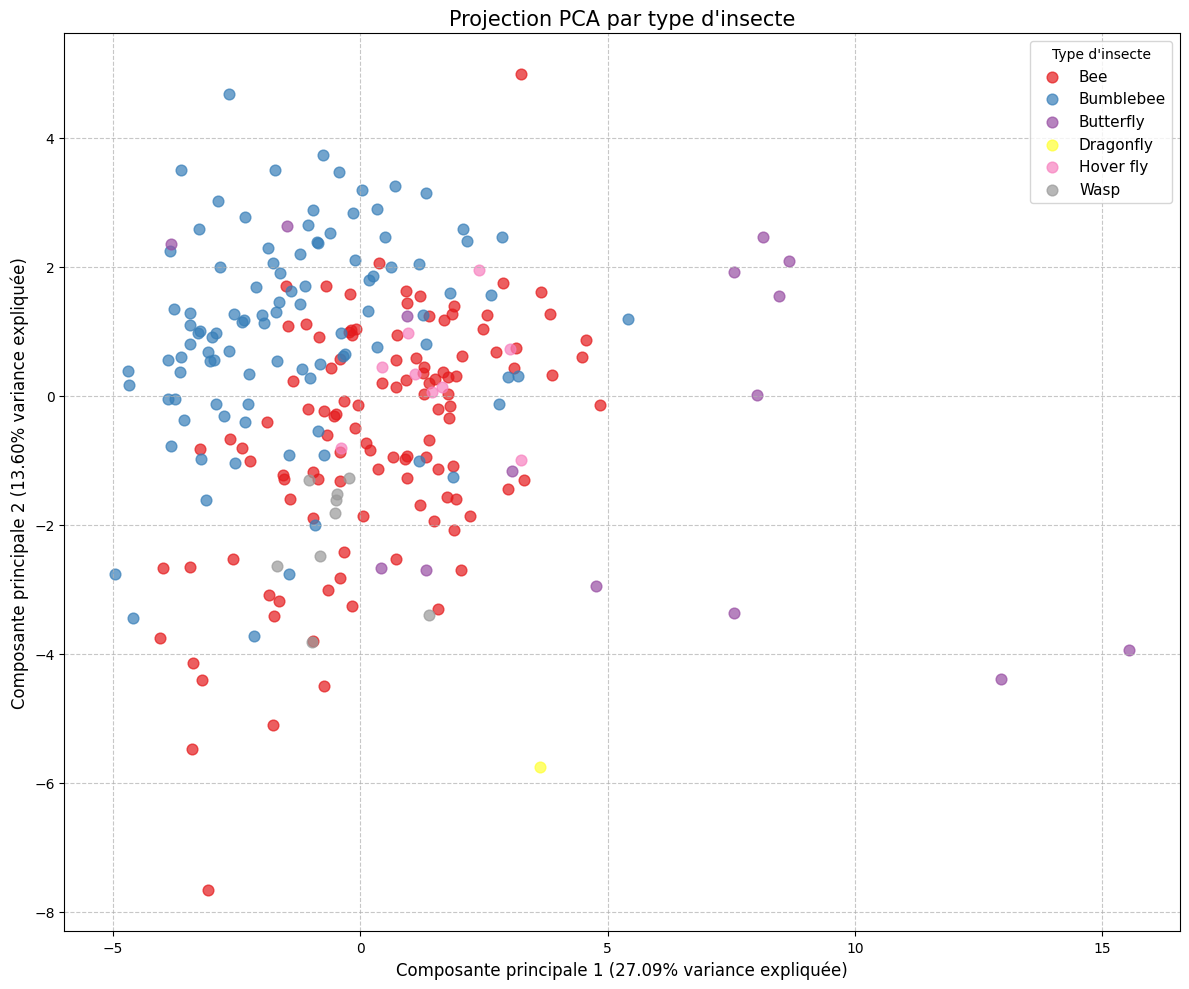

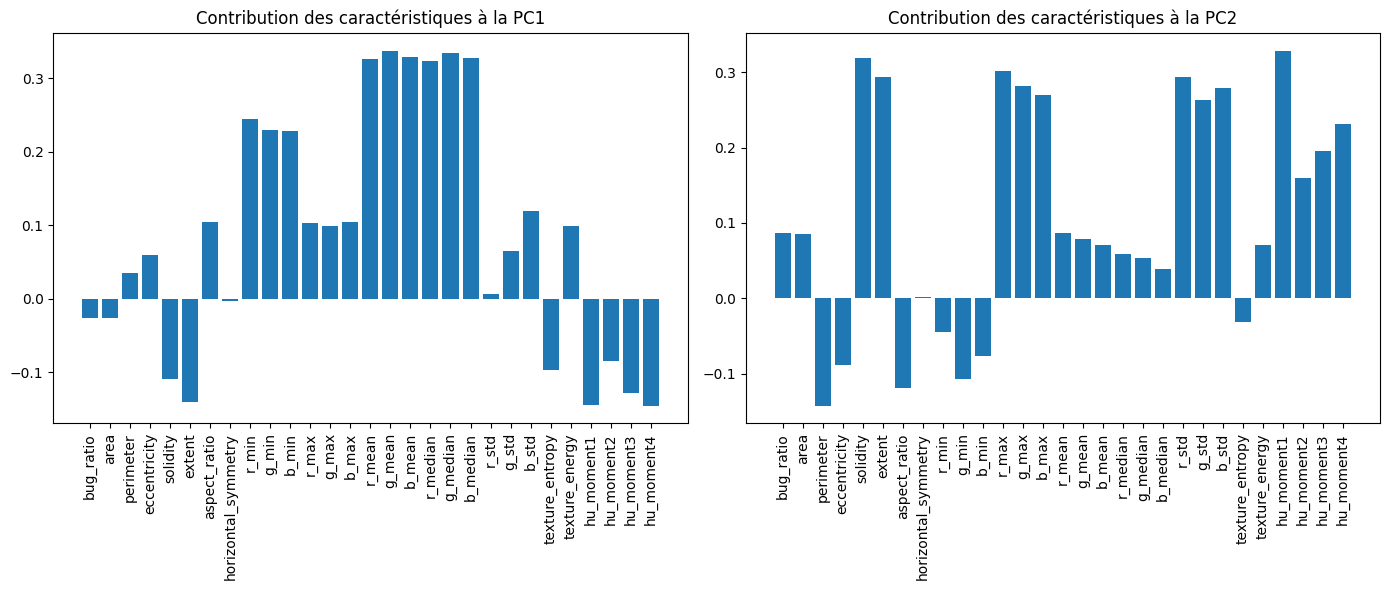

Calcul de t-SNE en cours...


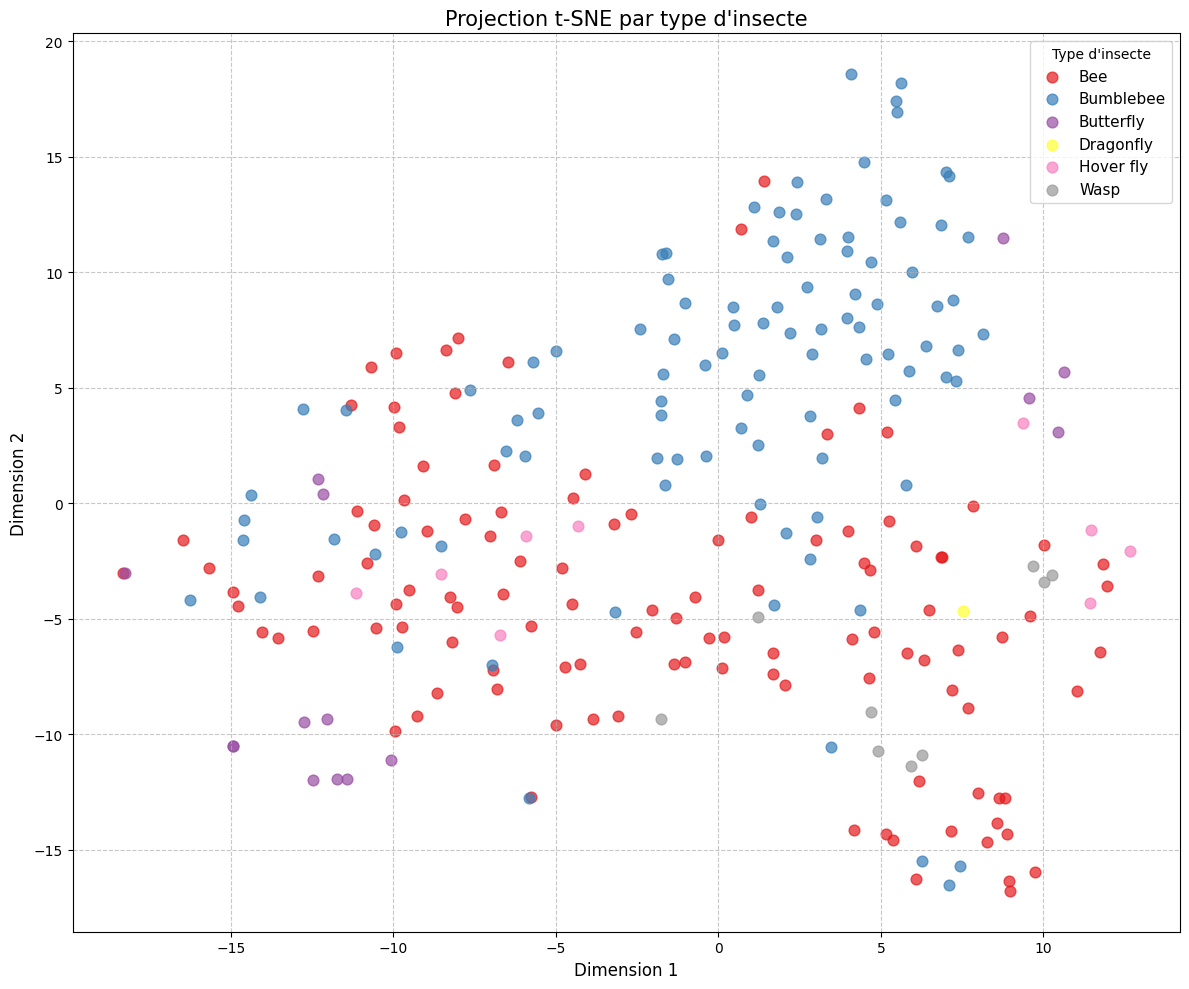

Calcul de UMAP en cours...


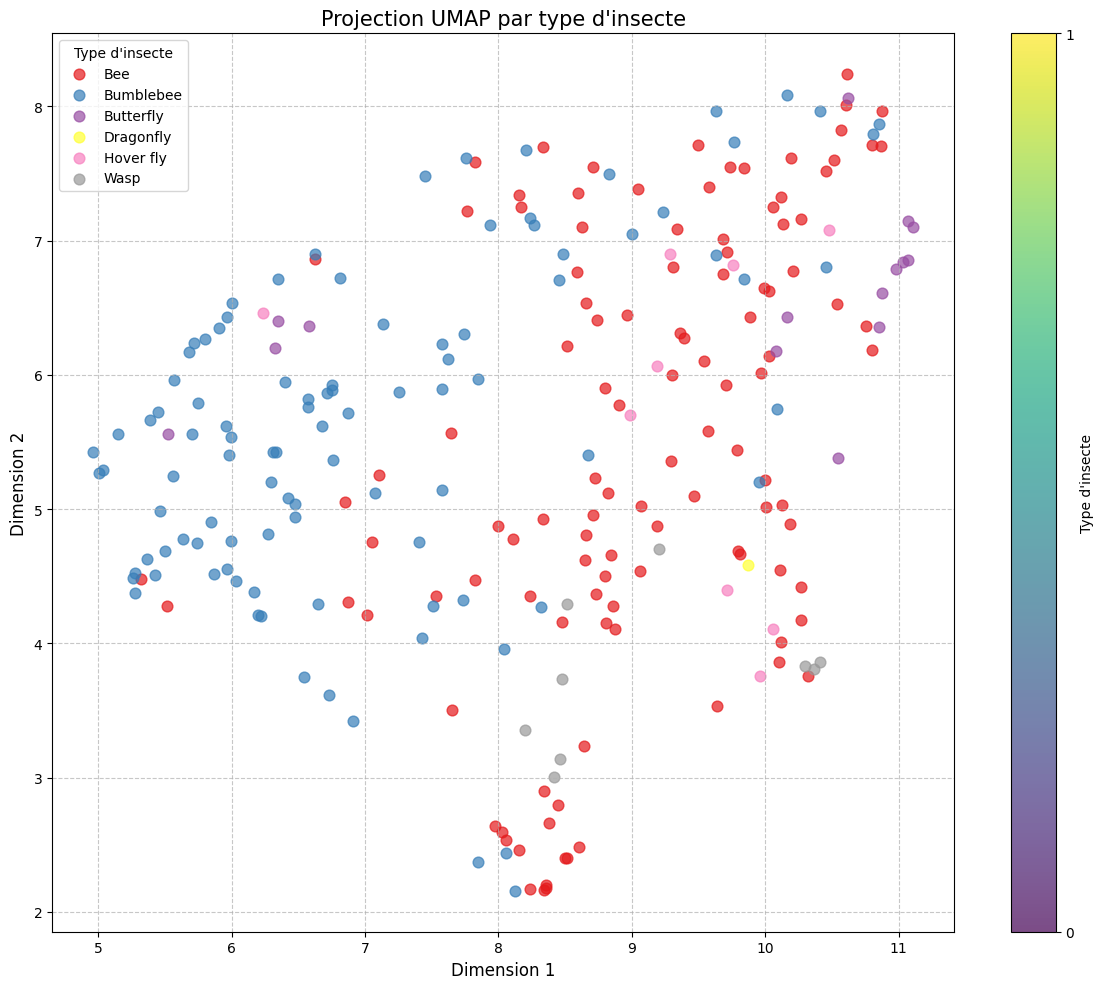

Calcul de ISOMAP en cours...


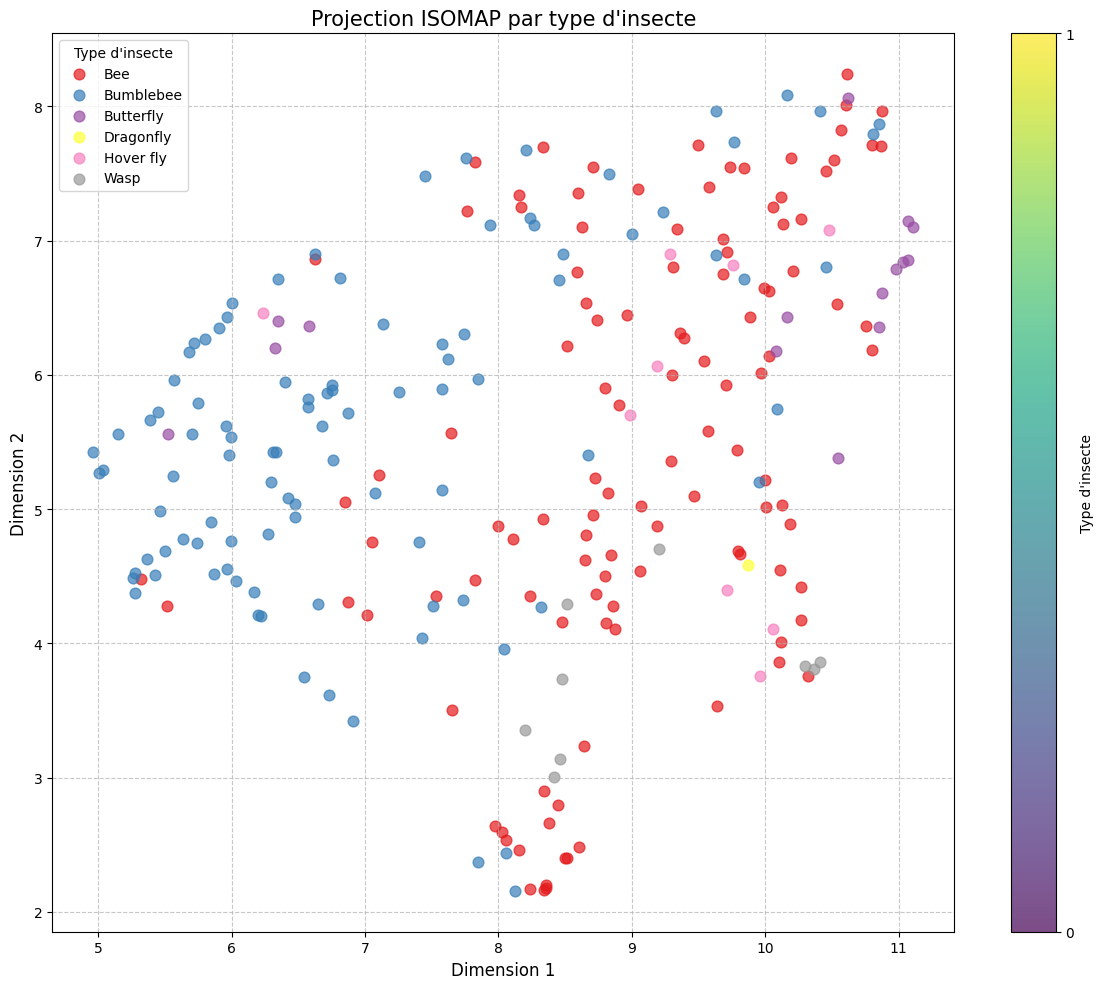

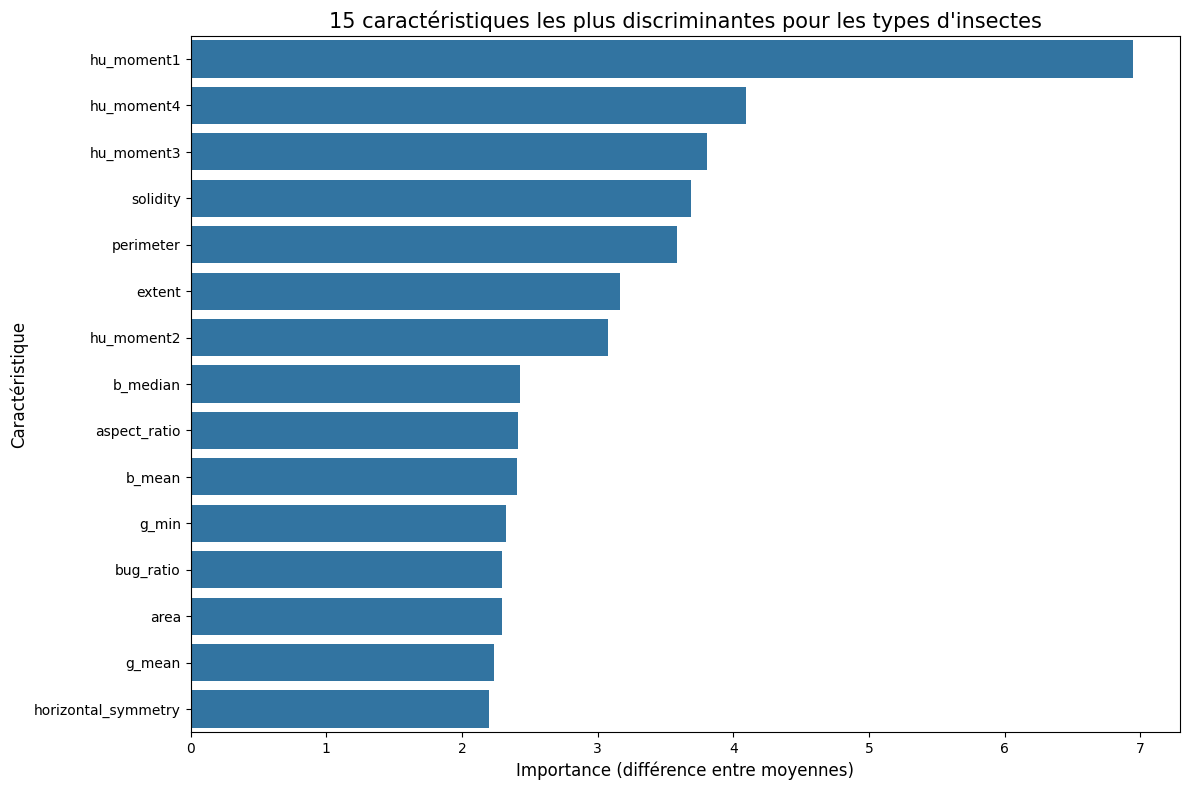

Analyse et visualisation des données terminées.
Les images ont été sauvegardées au format PNG pour le rapport.


In [4]:
# Charger les caractéristiques normalisées
features_df = pd.read_csv('features_normalized.csv')
print(f"Données chargées: {features_df.shape[0]} échantillons avec {features_df.shape[1]} caractéristiques")

# 1. Distribution des classes
# -----------------------------------------------

# Visualisation de la répartition des types d'insectes
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=features_df, x='bug_type')
ax.set_title('Répartition des types d\'insectes', fontsize=15)
ax.set_xlabel('Type d\'insecte', fontsize=12)
ax.set_ylabel('Nombre d\'échantillons', fontsize=12)

# Ajouter les valeurs sur les barres
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig('bug_type_distribution.png', dpi=300)
plt.show()

# Visualisation de la répartition des espèces
plt.figure(figsize=(14, 8))
ax = sns.countplot(data=features_df, y='species', order=features_df['species'].value_counts().index)
ax.set_title('Répartition des espèces', fontsize=15)
ax.set_xlabel('Nombre d\'échantillons', fontsize=12)
ax.set_ylabel('Espèce', fontsize=12)

# Ajouter les valeurs sur les barres
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('species_distribution.png', dpi=300)
plt.show()

# 2. Visualisation des caractéristiques clés par type d'insecte
# -----------------------------------------------

# Sélectionner quelques caractéristiques clés pour les boxplots
key_features = ['bug_ratio', 'area', 'perimeter', 'eccentricity', 'solidity', 
                'horizontal_symmetry', 'r_mean', 'g_mean', 'b_mean']

# Créer des boxplots pour chaque caractéristique clé
plt.figure(figsize=(15, 12))
for i, feature in enumerate(key_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='bug_type', y=feature, data=features_df)
    plt.title(f'{feature} par type d\'insecte')
    plt.tight_layout()

plt.savefig('key_features_boxplot.png', dpi=300)
plt.show()

# 3. Matrice de corrélation entre les caractéristiques
# -----------------------------------------------

# Sélectionner uniquement les colonnes numériques pour la corrélation
numeric_cols = features_df.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = [col for col in numeric_cols if col != 'image_id']

# Calculer la matrice de corrélation
correlation_matrix = features_df[numeric_cols].corr()

# Visualiser la matrice de corrélation
plt.figure(figsize=(16, 14))
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=False, mask=mask, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matrice de corrélation des caractéristiques', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300)
plt.show()

# 4. PCA - Projection linéaire en 2D
# -----------------------------------------------

# Préparer les données pour PCA
X = features_df[numeric_cols].values
y = features_df['bug_type'].values
species = features_df['species'].values

# Appliquer PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Visualiser les résultats de PCA
plt.figure(figsize=(12, 10))

# Obtenir les types uniques et créer une palette de couleurs
unique_types = np.unique(y)
colors = plt.cm.Set1(np.linspace(0, 1, len(unique_types)))

# Par type d'insecte avec scatter plot par groupe
for i, bug_type in enumerate(unique_types):
    mask = y == bug_type
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=[colors[i]], label=bug_type, alpha=0.7, s=60)

plt.title('Projection PCA par type d\'insecte', fontsize=15)
plt.xlabel(f'Composante principale 1 ({pca.explained_variance_ratio_[0]:.2%} variance expliquée)', fontsize=12)
plt.ylabel(f'Composante principale 2 ({pca.explained_variance_ratio_[1]:.2%} variance expliquée)', fontsize=12)
plt.legend(title='Type d\'insecte', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('pca_projection.png', dpi=300)
plt.show()

# Visualiser les loadings de PCA (contribution des caractéristiques)
plt.figure(figsize=(14, 6))
loadings = pca.components_.T
feature_names = numeric_cols

# Créer un graphique des loadings pour les deux premières composantes
plt.subplot(1, 2, 1)
indices = np.arange(len(feature_names))
plt.bar(indices, loadings[:, 0])
plt.xticks(indices, feature_names, rotation=90)
plt.title('Contribution des caractéristiques à la PC1')

plt.subplot(1, 2, 2)
plt.bar(indices, loadings[:, 1])
plt.xticks(indices, feature_names, rotation=90)
plt.title('Contribution des caractéristiques à la PC2')

plt.tight_layout()
plt.savefig('pca_loadings.png', dpi=300)
plt.show()

# 5. t-SNE - Projection non linéaire en 2D (méthode 1)
# -----------------------------------------------

# Appliquer t-SNE (peut prendre un peu de temps)
print("Calcul de t-SNE en cours...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)

# Visualiser les résultats de t-SNE
plt.figure(figsize=(12, 10))

# Par type d'insecte avec scatter plot par groupe
for i, bug_type in enumerate(unique_types):
    mask = y == bug_type
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
               c=[colors[i]], label=bug_type, alpha=0.7, s=60)

plt.title('Projection t-SNE par type d\'insecte', fontsize=15)
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)
plt.legend(title='Type d\'insecte', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('tsne_projection.png', dpi=300)
plt.show()

# 6. UMAP - Projection non linéaire en 2D (méthode 2)
# -----------------------------------------------

# Appliquer UMAP
print("Calcul de UMAP en cours...")
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X)

# Visualiser les résultats de UMAP
plt.figure(figsize=(12, 10))
for i, bug_type in enumerate(unique_types):
    mask = y == bug_type
    plt.scatter(X_umap[mask, 0], X_umap[mask, 1], c=[colors[i]], label=bug_type, alpha=0.7, s=60)

plt.legend(title='Type d\'insecte')
plt.title('Projection UMAP par type d\'insecte', fontsize=15)
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)
plt.colorbar(scatter, label='Type d\'insecte', ticks=[0, 1, 2])
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('umap_projection.png', dpi=300)
plt.show()

# 7. ISOMAP - Projection non linéaire en 2D (alternative)
# -----------------------------------------------

# Appliquer ISOMAP
print("Calcul de ISOMAP en cours...")
isomap = Isomap(n_components=2, n_neighbors=10)
X_isomap = isomap.fit_transform(X)

# Visualiser les résultats de ISOMAP
plt.figure(figsize=(12, 10))
for i, bug_type in enumerate(unique_types):
    mask = y == bug_type
    plt.scatter(X_umap[mask, 0], X_umap[mask, 1], c=[colors[i]], label=bug_type, alpha=0.7, s=60)
plt.legend(title='Type d\'insecte')
plt.title('Projection ISOMAP par type d\'insecte', fontsize=15)
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)
plt.colorbar(scatter, label='Type d\'insecte', ticks=[0, 1, 2])
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('isomap_projection.png', dpi=300)
plt.show()

# 8. Analyse de l'importance des caractéristiques pour la séparation des classes
# -----------------------------------------------

# Calculer la moyenne des caractéristiques par type d'insecte
feature_importance = pd.DataFrame()
bug_types = features_df['bug_type'].unique()

for feature in numeric_cols:
    values = []
    for bug_type in bug_types:
        avg_value = features_df[features_df['bug_type'] == bug_type][feature].mean()
        values.append(avg_value)
    
    # Calculer l'écart entre les moyennes (max - min)
    feature_importance.loc[feature, 'importance'] = max(values) - min(values)

# Trier par importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Visualiser les 15 caractéristiques les plus importantes
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance['importance'].head(15).values, 
            y=feature_importance.head(15).index)
plt.title('15 caractéristiques les plus discriminantes pour les types d\'insectes', fontsize=15)
plt.xlabel('Importance (différence entre moyennes)', fontsize=12)
plt.ylabel('Caractéristique', fontsize=12)
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300)
plt.show()

print("Analyse et visualisation des données terminées.")
print("Les images ont été sauvegardées au format PNG pour le rapport.")

In [ ]:
# 1. Chargement des données
features_df = pd.read_csv("features_normalized.csv")

# Supprimer les classes trop rares (< 2 exemples)
class_counts = y.value_counts()
valid_classes = class_counts[class_counts >= 2].index
filtered_df = features_df[features_df['bug_type'].isin(valid_classes)]

# Refaire X et y à partir du DataFrame filtré
X = filtered_df.drop(columns=['image_id', 'bug_type', 'species'])
y = filtered_df['bug_type']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # à faire avant train_test_split
joblib.dump(scaler, "scaler.joblib")

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# 2. Méthodes supervisées simples
print("K-Nearest Neighbors")
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print(classification_report(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))

print("Logistic Regression")
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)
print(classification_report(y_test, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))

# 3. Méthode d'ensemble
print("Random Forest")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

# 4. Clustering (non supervisé)
print("KMeans clustering")
kmeans = KMeans(n_clusters=len(np.unique(y_encoded)), random_state=42)
kmeans_labels = kmeans.fit_predict(X)
print("Silhouette Score (KMeans):", silhouette_score(X, kmeans_labels))

print("DBSCAN clustering")
dbscan = DBSCAN(eps=2.0, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)
# Vérifier que DBSCAN ne met pas tout en -1
if len(set(dbscan_labels)) > 1:
    print("Silhouette Score (DBSCAN):", silhouette_score(X, dbscan_labels))
else:
    print("DBSCAN n'a trouvé qu'un seul cluster.")

# 5. Recherche d'hyperparamètres : SVM + GridSearch
print("SVM avec GridSearchCV")
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}
svm = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
svm.fit(X_train, y_train)
print("Best Parameters:", svm.best_params_)

y_pred_svm = svm.predict(X_test)
print(classification_report(y_test, y_pred_svm))

# 6. Sauvegarde du meilleur modèle (si souhaité)
import joblib
joblib.dump(svm, "best_model.joblib")
joblib.dump(le, "label_encoder.joblib")

print("Pipeline terminé. Tous les modèles ont été évalués.")


K-Nearest Neighbors
              precision    recall  f1-score   support

           0       0.74      0.74      0.74        23
           1       0.70      0.95      0.81        20
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2

    accuracy                           0.72        50
   macro avg       0.29      0.34      0.31        50
weighted avg       0.62      0.72      0.66        50

Confusion Matrix:
 [[17  6  0  0  0]
 [ 1 19  0  0  0]
 [ 1  2  0  0  0]
 [ 2  0  0  0  0]
 [ 2  0  0  0  0]]
Logistic Regression
              precision    recall  f1-score   support

           0       0.81      0.57      0.67        23
           1       0.65      1.00      0.78        20
           2       0.50      0.33      0.40         3
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2

    accuracy                       

In [ ]:
# Charger les features extraites pour les images 251–347
test_df = pd.read_csv("test_features.csv")  # À générer comme tu l’as déjà fait
X_test_new = test_df.drop(columns=['image_id'])

# Normaliser avec le même scaler que les données d'entraînement
scaler = joblib.load("scaler.joblib")  # Si tu l’as sauvegardé
X_test_new_scaled = scaler.transform(X_test_new)

# Charger le meilleur modèle et le label encoder
model = joblib.load("best_model.joblib")
le = joblib.load("label_encoder.joblib")

# Prédiction
y_pred_test = model.predict(X_test_new_scaled)
pred_labels = le.inverse_transform(y_pred_test)

# Génération du fichier CSV
submission = pd.DataFrame({
    "ID": test_df['image_id'],
    "bug_type": pred_labels
})
submission.to_csv("submission.csv", index=False)
print("Fichier submission.csv généré.")


In [ ]:
# 1. Charger les features des images de test (251–347)
test_df = pd.read_csv("features_normalized.csv")

# 2. Sauvegarder les image_ids pour le CSV final
image_ids = test_df['image_id']

# 3. Supprimer les colonnes inutiles
X_test = test_df.drop(columns=['image_id', 'bug_type', 'species'], errors='ignore')

# 4. Charger le scaler utilisé pendant l'entraînement
scaler = joblib.load("scaler.joblib")
X_test_scaled = scaler.transform(X_test)

# 5. Charger le meilleur modèle et le label encoder
model = joblib.load("best_model.joblib")
le = joblib.load("label_encoder.joblib")

# 6. Faire les prédictions
y_pred_test = model.predict(X_test_scaled)
pred_labels = le.inverse_transform(y_pred_test)

# 7. Générer le fichier de soumission
submission = pd.DataFrame({
    "ID": image_ids,
    "bug_type": pred_labels
})
submission.to_csv("submission.csv", index=False)

print("Fichier submission.csv généré avec succès. Prêt à être remis !")


Fichier submission.csv généré avec succès. Prêt à être remis !
